In [ ]:
!nvidia-smi

Thu May 30 05:59:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
pip install numpy==1.22.4

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
SOURCE_VIDEO_PATH = "/content/Shopping, People, Commerce, Mall, Many, Crowd, Walking   Free Stock video footage   YouTube.mp4"

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.25 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.1/78.2 GB disk)


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 357MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [ ]:
model.model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - people for now{can be changed dynamically}
CLASS_ID = [0]


0: 384x640 27 persons, 4 backpacks, 2 handbags, 1 frisbee, 62.1ms
Speed: 3.2ms preprocess, 62.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


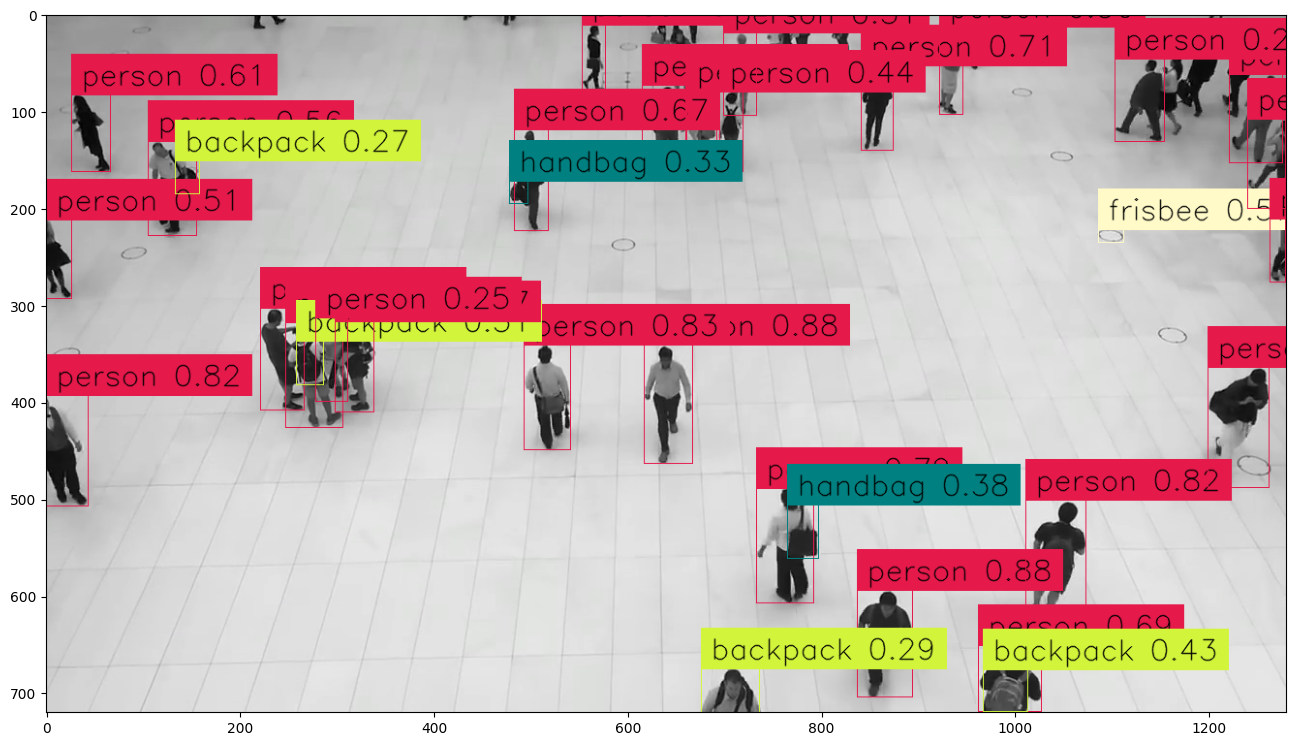

In [ ]:
SOURCE_VIDEO_PATH = '/content/Shopping, People, Commerce, Mall, Many, Crowd, Walking   Free Stock video footage   YouTube.mp4'  # Replace with your video path
FRAME_INDEX = 300  # Change this to the index of the desired frame

# Create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=1)

# Skip to the desired frame
frame = None
for i in range(FRAME_INDEX + 1):
    try:
        frame = next(generator)
    except StopIteration:
        print(f"Video has less than {FRAME_INDEX + 1} frames.")
        break

# Ensure the frame is obtained
if frame is not None:
    # Model prediction on single frame and conversion to supervision Detections
    results = model(frame)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )

    # Format custom labels
    labels = [
        f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for _, confidence, class_id, tracker_id
        in detections
    ]

    # Annotate and display frame
    frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

    # Display the frame
    %matplotlib inline
    show_frame_in_notebook(frame, (16, 16))
else:
    print("Failed to retrieve the specified frame.")

## Predict and annotate whole video

In [ ]:
# settings
LINE_START = Point(20, 350)
LINE_END = Point(1280-20, 350)

TARGET_VIDEO_PATH = f"{HOME}/Crowd_Counting.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=25, total_frames=341)

In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=1)
line_annotator = LineCounterAnnotator(thickness=1, text_thickness=2, text_scale=1)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/341 [00:00<?, ?it/s]


0: 384x640 29 persons, 4 handbags, 3 frisbees, 62.1ms
Speed: 2.1ms preprocess, 62.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 1 backpack, 1 handbag, 3 frisbees, 62.0ms
Speed: 2.2ms preprocess, 62.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 31 persons, 1 backpack, 1 handbag, 3 frisbees, 55.0ms
Speed: 6.2ms preprocess, 55.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 31 persons, 2 handbags, 3 frisbees, 53.9ms
Speed: 1.9ms preprocess, 53.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 31 persons, 2 handbags, 3 frisbees, 47.8ms
Speed: 2.0ms preprocess, 47.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 3 handbags, 2 frisbees, 35.7ms
Speed: 2.0ms preprocess, 35.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 28 persons, 2 handbags, 3 frisbees, 34.5ms
Speed: 3.3m